## Import Libraries

In [32]:
import wikipedia as wp
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import io
import requests

In [33]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


## Load and explore the data

In [34]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [10]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

store features from the data

In [35]:
neighborhoods_data = newyork_data['features']

Tranform the data into a pandas dataframe

In [36]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [37]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Verify the number of neighborhood

In [38]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Get the latitude and longitude values of New York City.

In [39]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with neighborhoods superimposed on top.

In [40]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

create a new dataframe of the Manhattan data.

In [41]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [42]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [43]:
# @hiddel_cell
CLIENT_ID = 'UVGPSXWCFSS1Z1ZLRCAAXTHJNBV4T2DM15TLG0LIBDIC0UQZ' # my Foursquare ID
CLIENT_SECRET = '1YRKMV2HSKR3PEUZ42WF22P3BNQGZV0IZOYF0ZV0E51JC1HU' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [44]:
address = '102 North End Ave, New York, NY'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7149555 -74.0153365


In [45]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [46]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.delivery.id', 'venue.delivery.provider.icon.name',
       'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes', 'venue.delivery.provider.name',
       'venue.delivery.url', 'venue.id', 'venue.location.address',
       'venue.location.cc', 'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [47]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Near by venues and locations

In [48]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Asphalt Green Battery Park City,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",40.715924,-74.014673
1,"Waterfront Plaza, Brookfield Place","[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",40.713241,-74.016241
2,Brookfield Place (BFPL),"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",40.713240,-74.015193
3,Irish Hunger Memorial,"[{'id': '4bf58dd8d48988d12d941735', 'name': 'M...",40.715139,-74.016557
4,Teardrop Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",40.716843,-74.015576


### Main facilities of nearby locations

In [49]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Asphalt Green Battery Park City,Athletics & Sports,40.715924,-74.014673
1,"Waterfront Plaza, Brookfield Place",Plaza,40.713241,-74.016241
2,Brookfield Place (BFPL),Shopping Mall,40.713240,-74.015193
3,Irish Hunger Memorial,Monument / Landmark,40.715139,-74.016557
4,Teardrop Park,Park,40.716843,-74.015576


In [50]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Park                    10
Coffee Shop              7
Hotel                    3
Playground               3
Memorial Site            3
Gym                      3
Wine Shop                2
Cocktail Bar             2
Gym / Fitness Center     2
Food Court               2
Name: categories, dtype: int64

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
# Nearby Venues
Newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [54]:
print('There are {} Uniques Categories.'.format(len(Newyork_venues['Venue Category'].unique())))
Newyork_venues.groupby('Neighborhood').count().head()

There are 449 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,34,34,34,34,34,34
Annadale,12,12,12,12,12,12
Arden Heights,7,7,7,7,7,7
Arlington,13,13,13,13,13,13
Arrochar,32,32,32,32,32,32


## One Hot encoding of features

In [57]:
# one hot encoding
Newyork_onehot = pd.get_dummies(Newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Newyork_onehot['Neighborhood'] = Newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Newyork_onehot.columns[-1]] + list(Newyork_onehot.columns[:-1])
Newyork_onehot = Newyork_onehot[fixed_columns]
Newyork_grouped = Newyork_onehot.groupby('Neighborhood').mean().reset_index()

In [58]:
num_top_venues = 5
for hood in Newyork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Newyork_grouped[Newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Allerton ----
            venue  freq
0      Donut Shop  0.12
1     Pizza Place  0.09
2     Supermarket  0.06
3             Bar  0.06
4  Sandwich Place  0.06


---- Annadale ----
                 venue  freq
0  American Restaurant  0.17
1          Pizza Place  0.17
2           Restaurant  0.17
3         Dance Studio  0.08
4                 Park  0.08


---- Arden Heights ----
           venue  freq
0       Pharmacy  0.14
1  Deli / Bodega  0.14
2   Home Service  0.14
3    Coffee Shop  0.14
4    Pizza Place  0.14


---- Arlington ----
                        venue  freq
0                    Bus Stop  0.23
1               Boat or Ferry  0.23
2               Deli / Bodega  0.15
3  Construction & Landscaping  0.08
4                 Snack Place  0.08


---- Arrochar ----
                venue  freq
0            Bus Stop  0.12
1      Baseball Field  0.09
2       Deli / Bodega  0.09
3  Italian Restaurant  0.06
4      Cosmetics Shop  0.06


---- Arverne ----
            venue  freq
0      

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


## Most common facilities near neighborhood

In [63]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Facility'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Facility'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Newyork_grouped['Neighborhood']

for ind in np.arange(Newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Facility,2nd Most Common Facility,3rd Most Common Facility,4th Most Common Facility,5th Most Common Facility,6th Most Common Facility,7th Most Common Facility,8th Most Common Facility,9th Most Common Facility,10th Most Common Facility
0,Allerton,Donut Shop,Pizza Place,Martial Arts School,Pharmacy,Fast Food Restaurant,Sandwich Place,Bus Station,Supermarket,Bar,Fried Chicken Joint
1,Annadale,Pizza Place,Restaurant,American Restaurant,Food,Diner,Train Station,Park,Deli / Bodega,Dance Studio,Falafel Restaurant
2,Arden Heights,Pharmacy,Deli / Bodega,Coffee Shop,Food,Bus Stop,Home Service,Pizza Place,Film Studio,Eye Doctor,Factory
3,Arlington,Bus Stop,Boat or Ferry,Deli / Bodega,Construction & Landscaping,Home Service,Grocery Store,Snack Place,Coffee Shop,Field,Zoo
4,Arrochar,Bus Stop,Deli / Bodega,Baseball Field,Cosmetics Shop,Beach,Italian Restaurant,Sculpture Garden,Plaza,Mediterranean Restaurant,Pharmacy


## Clustering neighbors with similar facilities

In [64]:
Newyork_grouped_clustering = Newyork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Newyork_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2,
       0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2,
       0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2,

In [75]:
Newyork_merged =neighborhoods.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Newyork_merged = Newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Newyork_merged.head()


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Facility,2nd Most Common Facility,3rd Most Common Facility,4th Most Common Facility,5th Most Common Facility,6th Most Common Facility,7th Most Common Facility,8th Most Common Facility,9th Most Common Facility,10th Most Common Facility
0,Bronx,Wakefield,40.894705,-73.847201,0,Gas Station,Pharmacy,Fried Chicken Joint,Caribbean Restaurant,Bakery,Fast Food Restaurant,Gift Shop,Pizza Place,Sandwich Place,Donut Shop
1,Bronx,Co-op City,40.874294,-73.829939,0,Accessories Store,Fast Food Restaurant,Bus Station,Print Shop,Men's Store,Bagel Shop,Harbor / Marina,Dumpling Restaurant,Trail,Grocery Store
2,Bronx,Eastchester,40.887556,-73.827806,0,Caribbean Restaurant,Fast Food Restaurant,Diner,Pizza Place,Burger Joint,Donut Shop,Shopping Mall,Grocery Store,Seafood Restaurant,Cocktail Bar
3,Bronx,Fieldston,40.895437,-73.905643,2,Plaza,Medical Supply Store,Home Service,Art Gallery,Moving Target,River,Park,Zoo,Fast Food Restaurant,Field
4,Bronx,Riverdale,40.890834,-73.912585,2,Bank,Park,Japanese Restaurant,Pizza Place,Mexican Restaurant,Playground,Italian Restaurant,Health & Beauty Service,Bagel Shop,Bar


In [69]:
kclusters = 10


In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Newyork_merged['Latitude'], 
                                   Newyork_merged['Longitude'], 
                                   Newyork_merged['Neighborhood'], 
                                   Newyork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


## Clustering by Housing price

In [77]:
df1=Newyork_merged.loc[Newyork_merged['Cluster Labels'] == 0,Newyork_merged.columns[[2] + list(range(5, Newyork_merged.shape[1]))]]
df2=Newyork_merged.loc[Newyork_merged['Cluster Labels'] == 1,Newyork_merged.columns[[2] + list(range(5, Newyork_merged.shape[1]))]]
df3=Newyork_merged.loc[Newyork_merged['Cluster Labels'] == 2,Newyork_merged.columns[[2] + list(range(5, Newyork_merged.shape[1]))]]

In [81]:
Newyork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":neighborhoods["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0
                                                              
                                                              
                                                              ]})


In [82]:
Newyork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

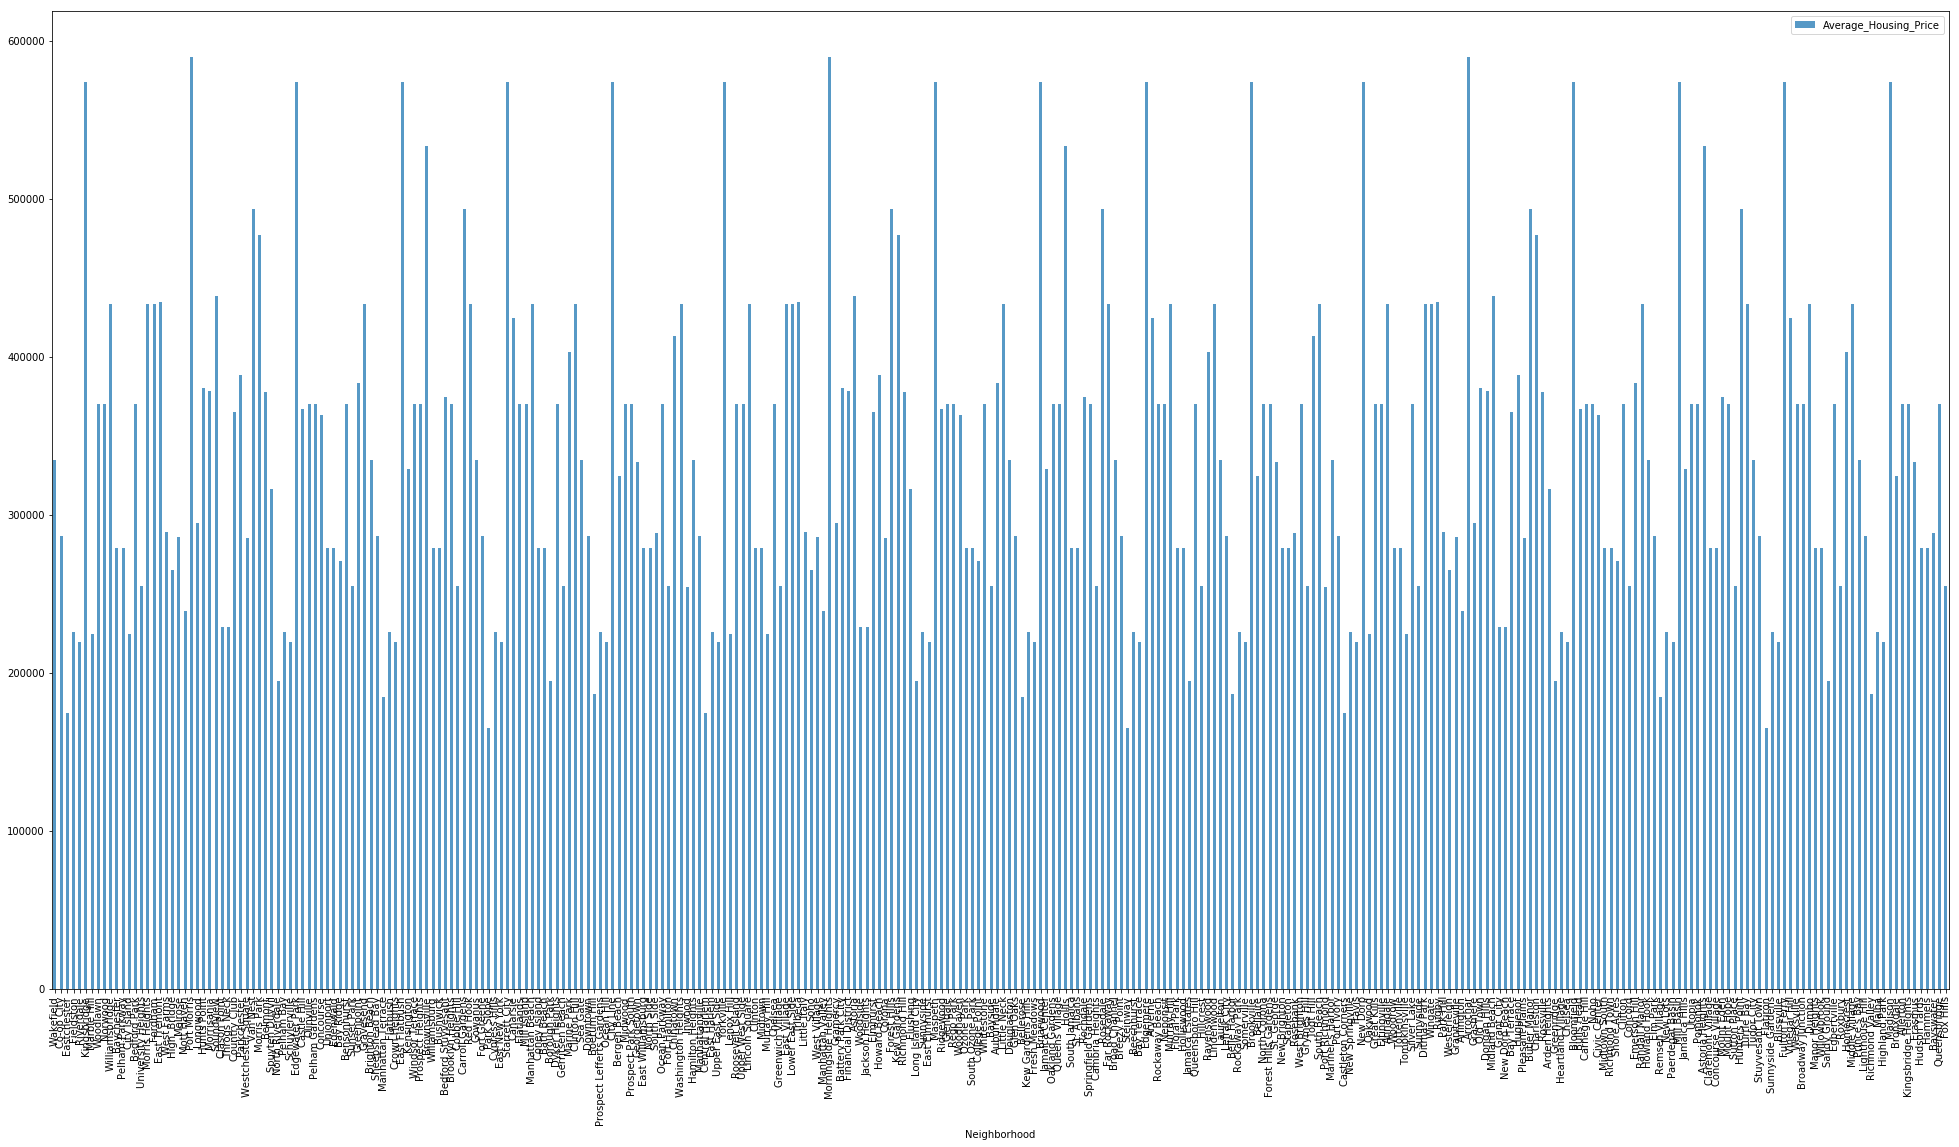

In [94]:
Newyork_Avg_HousingPrice.plot(kind='bar',figsize=(34,18),alpha=0.75)

### Clustering by School Rating

In [89]:
new_Newyork=Newyork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Newyork_school_ratings=pd.DataFrame({"Neighborhood":neighborhoods["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6
                                                           ]})




In [90]:
Newyork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

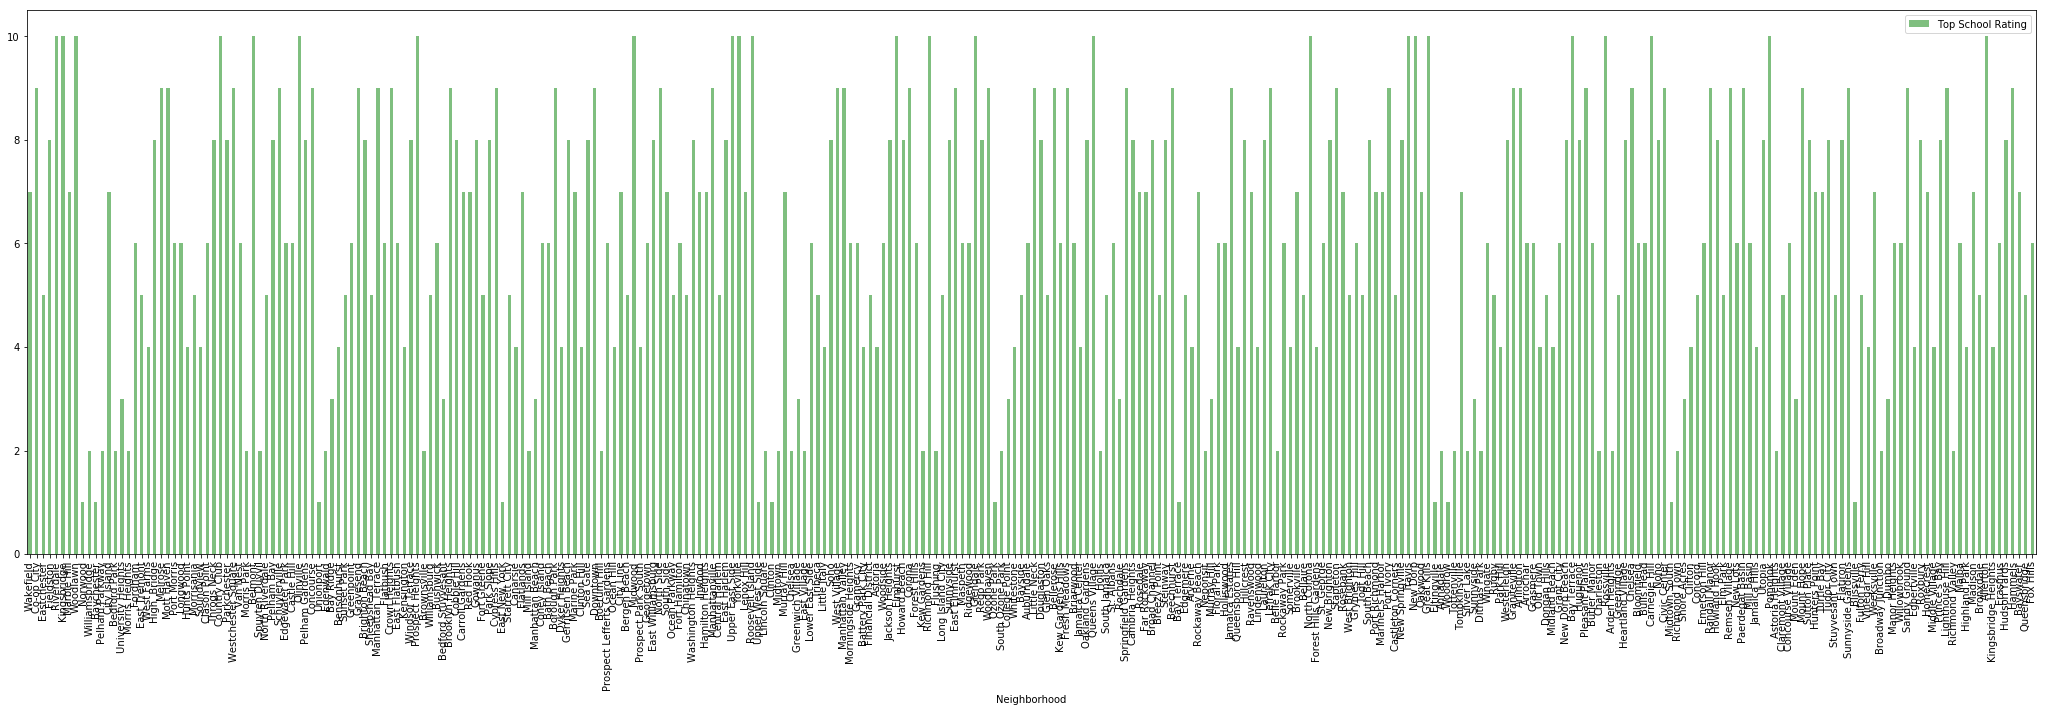

In [93]:
Newyork_school_ratings.plot(kind='bar',figsize=(36,10),color='green',alpha=0.5);